# Harmonic mean p-value for FWER correction

### Generate power spectra

In [2]:
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
import pandas as pd 
from tqdm import tqdm
import pickle
from joblib import Parallel, delayed

def generate_spectra(num_samples, sampling_rate, spectrum='mod4<2'):
    # Parameters
    frequencies = np.fft.rfftfreq(num_samples, 1 / sampling_rate)[1:]  # Frequency bins

    # Create alternating power spectrum 
    if spectrum == 'mod4<2':
        power_spectrum = np.array([2 if ii % 8 < 4 else 1.8 for ii in range(len(frequencies))])
    elif spectrum == 'mod4>2':
        power_spectrum = np.array([2 if jj % 8 >= 4 else 1.8 for jj in range(len(frequencies))])
    else: 
        power_spectrum = spectrum


    # Gamma distribution parameters
    shape = 1  # Shape parameter (k=1 for single bin, doubled for combined bins)

    # Sample power for individual bins using the alternating power spectrum
    single_bin_power = np.random.gamma(shape, power_spectrum)

    # Combine power for conjugate symmetric bins
    combined_power = []
    for i in range(len(frequencies)):
        if i == 0 or i == len(frequencies) - 1:  # DC or Nyquist, keep as is
            combined_power.append(single_bin_power[i])
        else:
            combined_power.append(
                np.random.gamma(shape, power_spectrum[i]) +
                np.random.gamma(shape, power_spectrum[i])
            )
    
    return np.array(combined_power)

In [3]:
N = 1000
num_samples = 200
# Create power spectra from 0.5 to 50 Hz
sampling_rate = 100
spectra_list_1 = []
spectra_list_2 = []
sample_list = []
for ii in range(N): 
    spectra_list_1.append(generate_spectra(num_samples, sampling_rate))
    spectra_list_2.append(generate_spectra(num_samples, sampling_rate, spectrum='mod4>2'))
    sample_list.extend([ii+1] * sampling_rate)

sample_list.extend(sample_list)
spectra_series_1 = pd.Series(np.vstack(spectra_list_1).flatten())
spectra_series_2 = pd.Series(np.vstack(spectra_list_2).flatten())

# Get frequencies for use in dataframe
frequencies = np.fft.rfftfreq(num_samples, 1 / sampling_rate)[1:]
    

Create spectra dataframe

In [4]:
spectra_df = pd.DataFrame(pd.concat([spectra_series_1, spectra_series_2], ignore_index=True), columns=["Spectra"])

freq_series = pd.Series(np.tile(frequencies, N*2))
spectra_df['Frequencies'] = freq_series
spectra_df['Population'] = pd.Series([1 if ii < (N * len(frequencies)) else 2 for ii in range(len(freq_series))])
spectra_df['Sample'] = pd.Series(sample_list)

In [5]:
spectra_df.head()

,Spectra,Frequencies,Population,Sample
0,0.149534,0.5,1,1
1,6.391011,1.0,1,1
2,1.382598,1.5,1,1
3,1.242408,2.0,1,1
4,5.559228,2.5,1,1


<Axes: xlabel='Frequencies', ylabel='Spectra'>

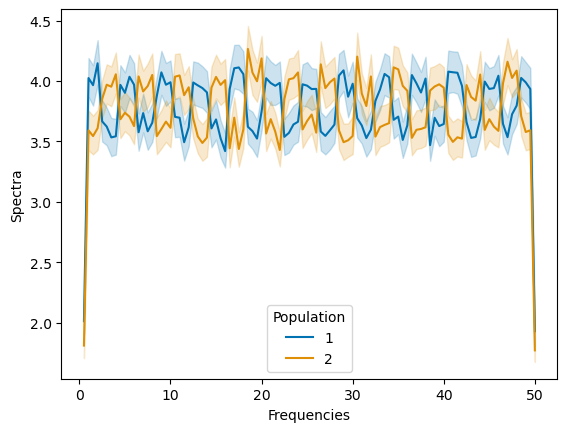

In [6]:
sns.lineplot(data=spectra_df, y='Spectra', x='Frequencies', hue='Population', palette='colorblind')

## Do permutation test for significance

Define necessary functions:
- Mean difference statistic for permutation test
- Landau density to calculate hmp
- Corrected mean p value calculation

In [7]:
from scipy.stats import false_discovery_control, hmean, permutation_test

from scipy import integrate

def mean_diff(x, y, axis):
    return np.mean(x, axis=axis) - np.mean(y, axis=axis)

def _landau_density(x, mu, sigma):
    """
    Copied from: github.com/benjaminpatrickevans/harmonicmeanp

    Computes the density of the Landau distribution. Note: This could be improved for efficiency,
    for example, using pylandau. Here I have used a naive implementation to keep dependencies small.
    """
    fn = lambda t:  np.exp(-t * ((x-mu)/sigma) - (2/np.pi) * t * np.log(t)) * np.sin(2 * t)
    return 1 / (mu * sigma) * integrate.quad(fn, 0, np.inf, limit=1000)[0]


def get_corrected_hmpval(hmpval, L, w_r=1.0):
    """
    Get the corrected harmonic mean p value.
    
    hmpval: harmonic mean p-value
    L: total number of tests
    w_r: sum of weights for the tests performed
    """
    mu = np.log(L) + 0.874
    sigma = np.pi / 2
    landau = lambda x: _landau_density(x, mu, sigma)
    res = integrate.quad(
        landau,
        w_r / hmpval,
        np.inf,
        limit=10000,
        epsabs=1e-6,
    )[0]
    return res

### Calculate p-values across a range of frequency bins and sample sizes 

In [8]:
def get_bin_average(spectra_df, bins=2, labels=None):
    '''
    Bin a dataframe with spectra values using input bin_size (float or int, in Hertz)
    '''
    # Bin the 'Frequency' column based on bin_size 
    if not isinstance(bins, list):
        bins = np.arange(0, spectra_df['Frequencies'].max() + bins, bins)
    spectra_df['Frequency_Bins'] = pd.cut(spectra_df['Frequencies'], 
                                bins=bins, labels=labels, right=False)

    # Group by the frequency bins and compute the mean of the 'Spectra' column
    result = spectra_df.groupby(['Population', 'Sample', 'Frequency_Bins'], observed=False)['Spectra'].mean().reset_index()

    return result



In [ ]:
def get_bin_average(spectra_df, bins=2, labels=None):
    '''
    Bin a dataframe with spectra values using input bin_size (float or int, in Hertz)
    '''
    # Bin the 'Frequency' column based on bin_size 
    if not isinstance(bins, list):
        bins = np.arange(0, spectra_df['Frequencies'].max() + bins, bins)
    spectra_df['Frequency_Bins'] = pd.cut(spectra_df['Frequencies'], 
                                bins=bins, labels=labels, right=False)

    # Group by the frequency bins and compute the mean of the 'Spectra' column
    result = spectra_df.groupby(['Population', 'Sample', 'Frequency_Bins'], observed=False)['Spectra'].mean().reset_index()

    return result



In [9]:
def p_correction(p_val_df):
    mean_p_val = {}
    bh = {}
    hmp = {}
    for name, group in p_val_df.groupby(['Bin', 'Sample Size']): 
        formatted_name = f'Bin: {name[0]}, Sample Size: {name[1]}'
        mean_p_val[formatted_name] = np.mean(group['P value'])
        bh[formatted_name] = np.mean(false_discovery_control(group['P value'], axis=0, method='bh'))
        hmp[formatted_name] = get_corrected_hmpval(hmean(group['P value']), len(group['P value']))
 
    return mean_p_val, bh, hmp

In [10]:
bin_sizes = [0.5]
sample_sizes = [25, 50, 100, 500, 1000]
statistic = mean_diff
df_dict = {}
df_dict['Bin'] = []
df_dict['Sample Size'] = []
df_dict['P value'] = []

for bin in bin_sizes:
    bin_df = get_bin_average(spectra_df, bin)
    x_df = bin_df[bin_df['Population'] == 1]
    y_df = bin_df[bin_df['Population'] == 2]
    for size in sample_sizes:
        sample_select = bin_df['Sample'].drop_duplicates().sample(size)
        sample_x = x_df[x_df['Sample'].isin(sample_select)]
        sample_y = y_df[y_df['Sample'].isin(sample_select)]
        x = sample_x.pivot(index='Sample', columns='Frequency_Bins', values='Spectra')
        y = sample_y.pivot(index='Sample', columns='Frequency_Bins', values='Spectra')
        res = permutation_test((x, y), statistic=statistic, vectorized=True, axis=0, n_resamples=10000)
        df_dict['Bin'].extend([bin] * len(res.pvalue))
        df_dict['Sample Size'].extend([size] * len(res.pvalue))
        df_dict['P value'].extend(res.pvalue)

In [19]:
x.head()

Frequency_Bins,"[0.0, 0.5)","[0.5, 1.0)","[1.0, 1.5)","[1.5, 2.0)","[2.0, 2.5)","[2.5, 3.0)","[3.0, 3.5)","[3.5, 4.0)","[4.0, 4.5)","[4.5, 5.0)",...,"[45.0, 45.5)","[45.5, 46.0)","[46.0, 46.5)","[46.5, 47.0)","[47.0, 47.5)","[47.5, 48.0)","[48.0, 48.5)","[48.5, 49.0)","[49.0, 49.5)","[49.5, 50.0)"
Sample,,,,,,,,,,,,,,,,,,,,,
1,NaN,0.149534,6.391011,1.382598,1.242408,5.559228,10.433350,3.849330,3.517687,4.168720,...,3.062143,3.365256,2.996119,1.424392,4.639447,1.368010,5.194174,2.647081,3.600556,15.673485
2,NaN,5.571097,1.395057,0.409248,11.383450,3.143638,3.016434,0.596604,4.423591,1.329782,...,2.300786,3.694046,6.344455,5.574525,8.401001,1.511602,6.182800,1.267507,5.969804,3.328012
3,NaN,2.008598,1.478360,6.104626,3.607655,1.069417,9.051610,2.414154,3.151804,2.565906,...,3.564725,13.523222,6.717306,1.214778,2.844606,2.441988,2.072168,3.713844,1.420746,2.459929
4,NaN,0.043285,5.065226,3.771972,0.661976,1.518739,1.452345,3.134336,3.606799,0.373087,...,6.040962,2.885446,5.090554,9.873990,7.767752,1.032325,5.852373,10.065622,8.900255,4.155159
5,NaN,3.351499,10.974059,4.149394,7.838292,0.477216,3.919887,3.663786,3.337726,2.800406,...,1.713323,4.369870,6.544499,2.398460,0.923650,9.710804,1.033898,4.609245,1.752647,3.457138


In [12]:
final_df = pd.DataFrame(df_dict)

In [13]:
final_df.head()

,Bin,Sample Size,P value
0,0.5,25,0.000200
1,0.5,25,0.848315
2,0.5,25,0.473753
3,0.5,25,0.582342
4,0.5,25,0.428757


In [14]:
corrected_p_vals = p_correction(final_df)

Show HMP vs corrected p values

In [15]:
# BH
corrected_p_vals[1]

{'Bin: 0.5, Sample Size: 25': np.float64(0.8108305381611052),
 'Bin: 0.5, Sample Size: 50': np.float64(0.6307974374773861),
 'Bin: 0.5, Sample Size: 100': np.float64(0.5234959249385678),
 'Bin: 0.5, Sample Size: 500': np.float64(0.10682949879945144),
 'Bin: 0.5, Sample Size: 1000': np.float64(0.011422418672333512)}

In [16]:
# Uncorrected
corrected_p_vals[0]

{'Bin: 0.5, Sample Size: 25': np.float64(0.457956204379562),
 'Bin: 0.5, Sample Size: 50': np.float64(0.3962343765623438),
 'Bin: 0.5, Sample Size: 100': np.float64(0.3465773422657735),
 'Bin: 0.5, Sample Size: 500': np.float64(0.08620337966203379),
 'Bin: 0.5, Sample Size: 1000': np.float64(0.009943005699430057)}

In [17]:
# HMP
corrected_p_vals[2]

{'Bin: 0.5, Sample Size: 25': 0.012076139772283319,
 'Bin: 0.5, Sample Size: 50': 0.00861534673751988,
 'Bin: 0.5, Sample Size: 100': 0.0033242646211025786,
 'Bin: 0.5, Sample Size: 500': 0.0013746847799554348,
 'Bin: 0.5, Sample Size: 1000': 0.00025160170570342387}

## Run simulations 1000 times to then plot behavior 

In [20]:
def process_iteration(ii):
    N = 1000
    num_samples = 200
    # Create power spectra from 0.5 to 50 Hz
    sampling_rate = 100
    spectra_list_1 = []
    spectra_list_2 = []
    sample_list = []
    for jj in range(N): 
        spectra_list_1.append(generate_spectra(num_samples, sampling_rate))
        spectra_list_2.append(generate_spectra(num_samples, sampling_rate, spectrum='mod4>2'))
        sample_list.extend([jj+1] * sampling_rate)

    sample_list.extend(sample_list)
    spectra_series_1 = pd.Series(np.vstack(spectra_list_1).flatten())
    spectra_series_2 = pd.Series(np.vstack(spectra_list_2).flatten())

    # Get frequencies for use in dataframe
    frequencies = np.fft.rfftfreq(num_samples, 1 / sampling_rate)[1:]

    spectra_df = pd.DataFrame(pd.concat([spectra_series_1, spectra_series_2], ignore_index=True), columns=["Spectra"])

    freq_series = pd.Series(np.tile(frequencies, N*2))
    spectra_df['Frequencies'] = freq_series
    spectra_df['Population'] = pd.Series([1 if ii < (N * len(frequencies)) else 2 for ii in range(len(freq_series))])
    spectra_df['Sample'] = pd.Series(sample_list)

    bin_sizes = [0.5]
    sample_sizes = [25, 50, 100, 500, 1000]
    statistic = mean_diff
    df_dict = {}
    df_dict['Bin'] = []
    df_dict['Sample Size'] = []
    df_dict['P value'] = []

    for bin in bin_sizes:
        bin_df = get_bin_average(spectra_df, bin)
        x_df = bin_df[bin_df['Population'] == 1]
        y_df = bin_df[bin_df['Population'] == 2]
        for size in sample_sizes:
            sample_select = bin_df['Sample'].drop_duplicates().sample(size)
            sample_x = x_df[x_df['Sample'].isin(sample_select)]
            sample_y = y_df[y_df['Sample'].isin(sample_select)]
            x = sample_x.pivot(index='Sample', columns='Frequency_Bins', values='Spectra')
            y = sample_y.pivot(index='Sample', columns='Frequency_Bins', values='Spectra')
            res = permutation_test((x, y), statistic=statistic, vectorized=True, axis=0, n_resamples=10000)
            df_dict['Bin'].extend([bin] * len(res.pvalue))
            df_dict['Sample Size'].extend([size] * len(res.pvalue))
            df_dict['P value'].extend(res.pvalue)
            
    final_df = pd.DataFrame(df_dict)
    return p_correction(final_df)


# Number of parallel processes (set to the number of CPU cores)
num_jobs = 2  # 2 cores for now since there is a high memory load 

# Run parallel iterations using joblib
all_dfs = Parallel(n_jobs=num_jobs)(delayed(process_iteration)(ii) for ii in tqdm(range(1000)))

import pickle
with open('output1_dot_95.pkl', 'wb') as file:
    pickle.dump(all_dfs, file)

/opt/anaconda3/envs/ieeg_pipe/lib/python3.12/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


KeyboardInterrupt: 

In [16]:
import pickle
with open('output.pkl', 'wb') as file:
    pickle.dump(all_dfs, file)

In [68]:
p_val_keys = ['Bonferroni', 'BH', 'HMP']
new_dict = {}
dict_list = []
for df in all_dfs:
    for ii, dict in enumerate(df):
        for key, value in dict.items():
            new_key = key.split(' ')[-1]
            new_dict[new_key] = value
        if ii == 0:
            power = [1 if v < (0.05 / float(new_key)) else 0 for v in new_dict.values()]
        else:
            power = [1 if v < 0.05 else 0 for v in new_dict.values()]
        new_df = pd.DataFrame(
            {
                'Correction Procedure': p_val_keys[ii],
                'Sample Size': new_dict.keys(),
                'P Value': [v for _, v in new_dict.items()],
                'Power': power
            }
        )
        dict_list.append(new_df)

final_df = pd.concat(dict_list)
            
    

<Axes: xlabel='Sample Size', ylabel='P Value'>

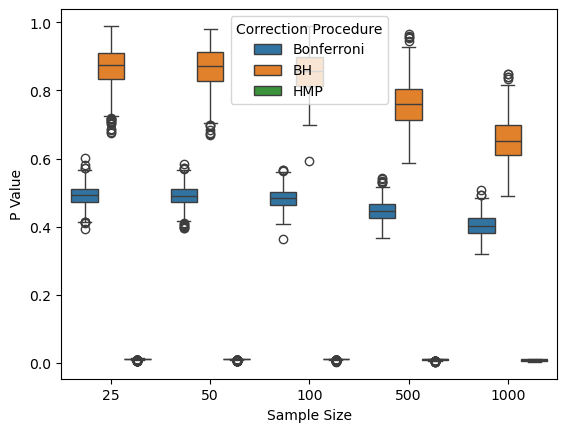

In [69]:
sns.boxplot(data=final_df, x='Sample Size', y='P Value', hue='Correction Procedure')

<Axes: xlabel='Sample Size', ylabel='Power'>

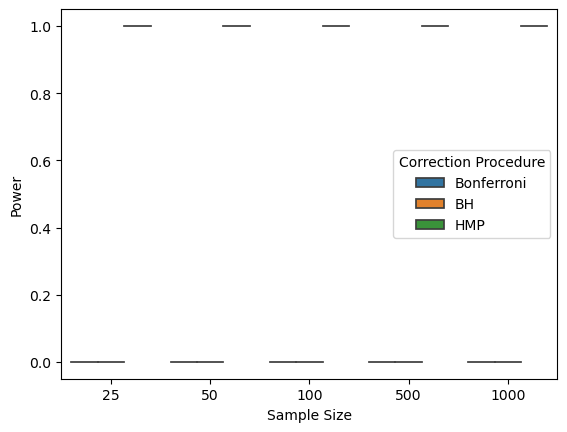

In [51]:
sns.violinplot(data=final_df, x='Sample Size', y='Power', hue='Correction Procedure')

### Perform testing with canonical frequency bands

In [126]:
bins = [0.5, 4, 8, 13, 30, 50]
labels = ['delta', 'theta', 'alpha', 'beta', 'gamma']

In [127]:
canon_df = get_bin_average(spectra_df, bins=bins, labels=labels)

<Axes: xlabel='Frequency_Bins', ylabel='Spectra'>

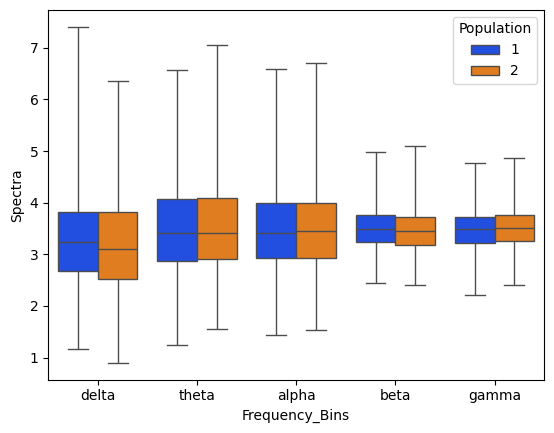

In [128]:
sns.boxplot(data=canon_df, x='Frequency_Bins', y='Spectra', hue='Population', whis=(0, 100), palette='bright')

In [54]:
bin_df = get_bin_average(spectra_df, bins, labels)
x_df = bin_df[bin_df['Population'] == 1]
y_df = bin_df[bin_df['Population'] == 2]
df_dict = {}
df_dict['Bin'] = labels * 5
df_dict['Sample Size'] = []
df_dict['P value'] = []
for size in sample_sizes:
    sample_select = bin_df['Sample'].drop_duplicates().sample(size)
    sample_x = x_df[x_df['Sample'].isin(sample_select)]
    sample_y = y_df[y_df['Sample'].isin(sample_select)]
    x = sample_x.pivot(index='Sample', columns='Frequency_Bins', values='Spectra')
    y = sample_y.pivot(index='Sample', columns='Frequency_Bins', values='Spectra')
    res = permutation_test((x, y), statistic=statistic, vectorized=True, axis=0, n_resamples=10000)
    df_dict['Sample Size'].extend([size] * 5)
    df_dict['P value'].extend(res.pvalue)

In [59]:
canon_df = pd.DataFrame(df_dict)
canon_df

,Bin,Sample Size,P value
0,delta,25,0.002200
1,theta,25,0.849115
2,alpha,25,0.862914
3,beta,25,0.221378
4,gamma,25,0.518748
5,delta,50,0.065993
6,theta,50,0.262174
7,alpha,50,0.446955
8,beta,50,0.634137
9,gamma,50,0.383562


In [57]:
canon_p_vals = p_correction(canon_df)

In [60]:
canon_p_vals['HMP']

[2.116098661065342,
 1.5978152187402705,
 2.1334812735382016,
 1.7022284355480644,
 1.4601988614846453,
 0.9624518572929193,
 1.8944776425479817,
 1.2365498878562236,
 0.011113650776885045,
 0.02392414238883942,
 0.007413129080583476,
 0.2810464085471273,
 2.0947159184473456,
 2.1126158557500814,
 1.4057213895206369,
 1.728951103242202,
 1.4582774294964593,
 0.2977199770712368,
 1.9303633325098972,
 0.7509038290379665,
 2.105554323583666,
 1.1090963312198319,
 2.1719723256247163,
 0.451808272173252,
 0.1889884380009488]

## Coherence 

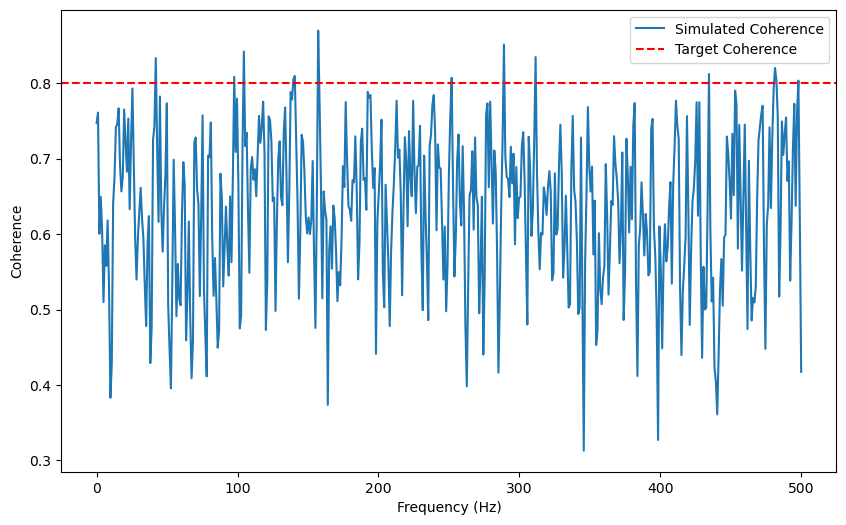

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import coherence

# Parameters
fs = 1000  # Sampling frequency
N = 10000  # Number of samples
freqs = np.fft.rfftfreq(N, 1/fs)  # Frequency axis
target_coherence = 0.8  # Desired coherence

# Generate random independent signals in the frequency domain
np.random.seed(0)
noise1 = np.random.normal(size=N)
noise2 = np.random.normal(size=N)
fft1 = np.fft.rfft(noise1)
fft2 = np.fft.rfft(noise2)

# Adjust magnitudes (define PSDs)
psd1 = np.abs(fft1) ** 2
psd2 = np.abs(fft2) ** 2
fft1 = fft1 / np.abs(fft1) * np.sqrt(psd1)
fft2 = fft2 / np.abs(fft2) * np.sqrt(psd2)

# Impose phase relationship for desired coherence
phase_diff = np.arccos(np.sqrt(target_coherence))  # Phase difference
fft2 = np.abs(fft2) * np.exp(1j * (np.angle(fft1) + phase_diff))

# Transform back to time domain
ts1 = np.fft.irfft(fft1, N)
ts2 = np.fft.irfft(fft2, N)

# Validate coherence
f, Cxy = coherence(ts1, ts2, fs=fs, nperseg=1024)

# Plot
plt.figure(figsize=(10, 6))
plt.plot(f, Cxy, label="Simulated Coherence")
plt.axhline(target_coherence, color="r", linestyle="--", label="Target Coherence")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Coherence")
plt.legend()
plt.show()


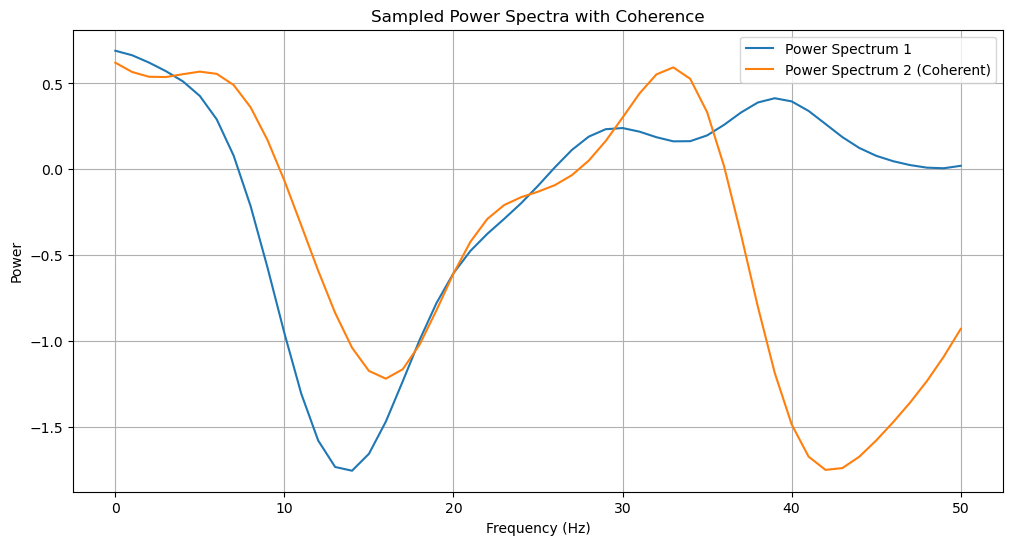

In [83]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C

# Frequencies
sampling_rate = 100  # Hz
duration = 1.0  # seconds
frequencies = np.linspace(0, sampling_rate / 2, int(sampling_rate * duration / 2) + 1)

# Define kernels
kernel = C(1.0, (1e-2, 1e2)) * RBF(length_scale=5.0, length_scale_bounds=(1e-2, 1e2))

# Gaussian Process for Power Spectrum 1
gp1 = GaussianProcessRegressor(kernel=kernel, alpha=1e-6)
mean1 = np.zeros(len(frequencies))
cov1 = kernel(frequencies[:, None], frequencies[:, None])
power_spectrum1 = np.random.multivariate_normal(mean1, cov1)

# Gaussian Process for Power Spectrum 2 (with coherence)
coherence = 0.8  # Desired coherence level
cross_cov = coherence * cov1  # Simplified cross-covariance
cov_joint = np.block([[cov1, cross_cov], [cross_cov, cov1]])
mean_joint = np.zeros(2 * len(frequencies))

# Sample joint power spectra
joint_spectra = np.random.multivariate_normal(mean_joint, cov_joint).reshape(2, -1)
power_spectrum2 = joint_spectra[1]

# Plot results
plt.figure(figsize=(12, 6))
plt.plot(frequencies, power_spectrum1, label="Power Spectrum 1")
plt.plot(frequencies, power_spectrum2, label="Power Spectrum 2 (Coherent)")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Power")
plt.title("Sampled Power Spectra with Coherence")
plt.legend()
plt.grid()
plt.show()


# Analyze publicly available EEG data 